## Imports

In [74]:
#Python3.10
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pymannkendall as mk
import contextily as cx

from sklearn.preprocessing import MinMaxScaler
from dateutil import relativedelta
from datetime import datetime
from shapely.geometry import Point

from dataretrieval import nwis, utils, codes

# TODO: Look into the warning that this is disabling. It doesn't appear to be significant for the purposes of this code but it needs to be understood
pd.options.mode.chained_assignment = None
#pd.options.mode.chained_assignment = 'warn'

## Classes

In [4]:
class StreamGauge:
    def __init__(self, id, name, mean_start_date, mean_end_date, post_start_date, post_end_date):
        self.id = id
        self.name = name
        # Start date for all-time mean daily flow data
        self.mean_start_date = mean_start_date
        self.mean_end_date = mean_end_date
        # Start date for post-impairment mean daily flow data
        self.post_start_date = post_start_date
        self.post_end_date = post_end_date 
        
    def get_id(self):
        """Return stream gauge USGS ID"""
        return self.id  
    
    def get_name(self):
        return self.name     
        
    def get_mean_date_range(self):
        """Return a time delta object between the start and end of the full record of streamflow data"""
        start_date = datetime.strptime(self.mean_start_date, "%Y-%m-%d")
        end_date = datetime.strptime(self.mean_end_date, "%Y-%m-%d")
        return relativedelta.relativedelta(end_date, start_date)
    
    def get_post_date_range(self):
        """Return a time delta object between the start and end of the post-impairment record of streamflow data"""
        start_date = datetime.strptime(self.post_start_date, "%Y-%m-%d")
        end_date = datetime.strptime(self.post_end_date, "%Y-%m-%d")
        return relativedelta.relativedelta(end_date, start_date)

## Inputs

In [5]:
# 11447650 -- Sacramento River Basin
# 11303500 -- San Joaquin-Tulare Basin
# SRB -- '1970-01-01' '2014-01-01'
# SJTB -- '1989-01-01' '2014-01-01'
# Water year -- Oct 1-Sept 30
        
SRB_Guage = StreamGauge('11447650', 'SACRAMENTO R A FREEPORT CA', '1948-10-01', '2014-09-30', '1970-10-01', '2014-09-30')
SJTB_Guage = StreamGauge('11303500', 'SAN JOAQUIN R NR VERNALIS CA', '1923-10-01', '2014-09-30', '1989-10-01', '2014-09-30')

# Change this to modify analysis values
curr_guage = SJTB_Guage

# Sorty by Watershed Boundary
SORT_BY_WB = True

QUANTILE = 0.90
STATE_CODE = 'CA'
HYDRO_YEAR = 'AS-OCT'
SERVICE = 'dv'
MIN_DATA_PERIOD = 50
MAX_MISSING_THRESHOLD = 0.90
MK_TREND_ALPHA = 0.05

# 00060 -- Discharge
# 00010 -- Temperature
PARAM_CODE = '00060'

# Site ID URI
SITES_URI = f'https://waterdata.usgs.gov/{STATE_CODE}/nwis/current?index_pmcode_STATION_NM=1&index_pmcode_DATETIME=2&index_pmcode_{PARAM_CODE}=3&group_key=NONE&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=dec_lat_va&column_name=dec_long_va&column_name=sv_begin_date&column_name=sv_end_date&sort_key_2=site_no&html_table_group_key=NONE&rdb_compression=file&list_of_search_criteria=realtime_parameter_selection'

## Functions

In [6]:
# CONSTANTS
SEC_PER_DAY = 86400
CUBIC_FT_KM_FACTOR = 0.0000000000283168466

# FUNCTIONS
def validate(df: pd.DataFrame, start: datetime, end: datetime, report: bool):
    """Validates that no more than MAX_MISSING_THRESHOLD (10%) of data is missing from a given gauge"""
    t_delta = pd.to_datetime(end) - pd.to_datetime(start)
    days = t_delta.days           
    return ((len(df) / days) > MAX_MISSING_THRESHOLD)

def calc_threshold(df: pd.DataFrame, value: float):
    """Returns a threshold above which flow is considered HMF given flow values and a threshold 0 < t < 1""" 
    df = pd.DataFrame(df['00060_Mean'])
    return df.quantile(q=value, axis=0).iloc[0]

def filter_hmf(df: pd.DataFrame, threshold: float):
    """Returns a dataframe with only flow values above a given threshold present"""
    return df[df['00060_Mean'] > threshold]

def convert_hmf(df: pd.DataFrame, threshold: float):
    """Converts flow values from ft^3/s to ft^3/day and returns only excess flow above a given threshold"""
    return (df['00060_Mean'] - threshold) * SEC_PER_DAY

def num_hmf_years(df: pd.DataFrame, offset: int):
    """Returns the integer number of HMF years, using an offset to indicate the start of the Hydrologic Year (i.e. 10 = October)"""
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)    
    df.loc[:, 'offsetdate'] = (df.index - pd.offsets.YearBegin(month=offset))    
    return df['offsetdate'].dt.year.nunique()

def three_six_range(df: pd.DataFrame, three_start: int, three_end: int, six_start: int, six_end: int):
    """Returns two dataframes, one with a six month period, and one with a three month period, based on given start and end months for both"""
    df = df.reset_index()
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])    
    six_month_mask = (df['datetime'].dt.month >= six_start) | (df['datetime'].dt.month <= six_end)
    three_month_mask = (df['datetime'].dt.month >= three_start) | (df['datetime'].dt.month <= three_end)
    return df[six_month_mask], df[three_month_mask]

def calc_duration(df: pd.DataFrame):
    """Returns the total number of HMF days over the dataframes time period"""
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)  
    df_results = df.resample(HYDRO_YEAR).agg({'00060_Mean': ['count']})
    df_results.columns = ['Count']
    return df_results['Count'].sum()
    
def convert_cubic_ft_hm(value: float):
    """Convert ft^3 to km^3"""
    return value * CUBIC_FT_KM_FACTOR

def mann_kendall(data: pd.Series, alpha: float):
    """Perform a Mann-Kendall Trend test"""
    return mk.original_test(data, alpha=alpha)
    

## Single Site Data<br>

In [7]:
# df2 holds all-time data, df is analyzed range
df = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.post_start_date, end=curr_guage.post_end_date)
df2 = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.mean_start_date, end=curr_guage.mean_end_date)

# If looking at a post impairment period, but calculating threshold based on the full record of data, pass a second dataframe with a different 
# start/end date as df2, otherwise pass df twice
def single_site_data(df: pd.DataFrame, df2: pd.DataFrame, start: datetime, end: datetime):
    df = df.reset_index()
    df2 = df2.reset_index()
    #df2.to_csv('srb_full.csv')
    #print(f'Statistics for {curr_guage.get_name()}')
    
    # Validate that site is not missing > 10% of data
    valid = validate(df, start, end, True)
    
    # 90th percentile calculation
    threshold = calc_threshold(df2, QUANTILE)    

    # Create a dataframe with only days over HMF threshold 
    hmf_series = filter_hmf(df, threshold)
    
    # Aggregate data before performing MK, filter out non-HMF years
    agg_series = pd.DataFrame(hmf_series)
    agg_series.set_index('datetime', inplace=True)
    agg_series = agg_series.resample(HYDRO_YEAR).agg({'00060_Mean': ['sum', 'count']})
    agg_series.columns = ['Sum', 'Count']
    agg_series = agg_series[agg_series['Sum'] > 0]
    #print(agg_series)
    
    mk_result = mann_kendall(agg_series['Sum'], MK_TREND_ALPHA)
    #print(mk_result.trend, mk_result.slope)

    # Find number of years with HMF 
    hmf_years = num_hmf_years(hmf_series, 10)    

    # Mask out months that don't fall within 3 and 6 month Winter range
    df_six_month, df_three_month = three_six_range(hmf_series, 12, 2, 11, 4)

    # Convert to daily average flow in cfps, and take only flow above the threshold
    hmf_series = convert_hmf(hmf_series, threshold)
    total_hmf_flow = hmf_series.sum()
    #print(f'Total Volume of HMF: {total_hmf_flow}')

    # Calculate 3 and 6 month HMF
    df_six_month = convert_hmf(df_six_month, threshold)
    six_month_hmf = df_six_month.sum()
    df_three_month = convert_hmf(df_three_month, threshold)
    three_month_hmf = df_three_month.sum()

    # Inter-annual and Duration Calculation (across the full record)
    hmf_series_full = filter_hmf(df2, threshold)
    hmf_years_full = num_hmf_years(hmf_series_full, 10)

    delta = curr_guage.get_mean_date_range()
    inter_annual = (hmf_years_full / (delta.years + 1)) * 100

    # Average Duration
    hmf_series_dur = filter_hmf(df, threshold)
    hmf_series_dur = pd.DataFrame(hmf_series_dur)
    duration = calc_duration(hmf_series_dur)
    avg_duration = duration / hmf_years
    
    total_hmf_flow = (total_hmf_flow * CUBIC_FT_KM_FACTOR) / hmf_years
    six_month_hmf = (six_month_hmf * CUBIC_FT_KM_FACTOR) / hmf_years
    three_month_hmf = (three_month_hmf * CUBIC_FT_KM_FACTOR) / hmf_years
    
    # Merging site dataframe with Mann-Kendall dataframe
    data = {'site_no': df.iloc[0]['site_no'], 'valid': valid, 'threshold': threshold, 'hmf_years': hmf_years, 'hmf_per_year': total_hmf_flow, 
            'six_mo_hmf': six_month_hmf, 'three_mo_hmf': three_month_hmf, 'duration': avg_duration, 'inter_annual': inter_annual}   
    
    df_single_site = pd.DataFrame(data, index=['0'])
    mk_data = pd.DataFrame([mk_result], columns=['mk_trend', 'mk_h', 'mk_p', 'mk_z', 'mk_tau', 'mk_s', 'mk_var_s', 'mk_slope', 'mk_int'], index=['0'])
    
    df_single_site = pd.concat([df_single_site, mk_data], axis=1)
    #df_single_site.to_csv('combined.csv')
    return df_single_site

df_single_site = single_site_data(df, df2, curr_guage.post_start_date, curr_guage.post_end_date)

def single_site_report(df_single_site: pd.DataFrame):
    print(f'Site No: {df_single_site["site_no"].to_string(index=False)}')
    print(f'Valid: {df_single_site["valid"].to_string(index=False)}')
    print(f'90%: {df_single_site["threshold"].to_string(index=False)}')
    print(f'HMF Years: {df_single_site["hmf_years"].to_string(index=False)}')
    print(f'Average Duration: {df_single_site["duration"].to_string(index=False)}')
    print(f'Inter-annual Frequency: {df_single_site["inter_annual"].to_string(index=False)}%')
    print(f'Total HMF in km^3/year: {df_single_site["hmf_per_year"].to_string(index=False)}')
    print(f'6 Month HMF in km^3/year: {df_single_site["six_mo_hmf"].to_string(index=False)}')
    print(f'3 Month HMF in km^3/year: {df_single_site["three_mo_hmf"].to_string(index=False)}')
    print(f'MK Trend: {df_single_site["mk_trend"].to_string(index=False)}')
    print(f'MK Slope: {df_single_site["mk_slope"].to_string(index=False)}')
    
single_site_report(df_single_site)


Site No: 11303500
Valid: True
90%: 11600.0
HMF Years: 9
Average Duration: 79.111111
Inter-annual Frequency: 42.857143%
Total HMF in km^3/year: 1.620095
6 Month HMF in km^3/year: 1.187513
3 Month HMF in km^3/year: 0.54613
MK Trend: no trend
MK Slope: -710.0


## Multi-Site Filtering<br>

In [9]:
import requests
import sys
from io import StringIO
from IPython.display import clear_output
import time

shapefile_path = f'ShapeFiles/CA/Central/South_Central/WBDHU4.shp'

def filter_multi_site(shapefile_path):
    """Creates a list of sites with over 50 years of 00060_Mean streamflow data for a given region"""
    # Request page from USGS site, ignore all informational lines
    response = requests.get(SITES_URI)
    data = response.text
    lines = data.splitlines()
    lines = [line for line in lines if not line.startswith('#')]

    # Create dataframe where site_no is a list of all sites in a state with 00060 data
    tsd = "\n".join(lines)
    df = pd.read_csv(StringIO(tsd), sep='\t')
    df_state_sites = df.iloc[1:]

    # Filter out sites with <30 years of data
    df_state_sites['sv_begin_date'] = pd.to_datetime(df_state_sites['sv_begin_date'])
    df_state_sites['sv_end_date'] = pd.to_datetime(df_state_sites['sv_end_date'])
    df_state_sites['data_period'] = (df_state_sites['sv_end_date'] - df_state_sites['sv_begin_date']).dt.days / 365.25
    df_state_sites = df_state_sites[df_state_sites['data_period'] >= MIN_DATA_PERIOD]

    # Filter out sites outside of HU boundary
    if SORT_BY_WB:
        shapefile = gpd.read_file(shapefile_path)
        df_state_sites['geometry'] = [Point(lon, lat) for lon, lat in zip(df_state_sites['dec_long_va'], df_state_sites['dec_lat_va'])]
        gdf_data = gpd.GeoDataFrame(df_state_sites, crs=shapefile.crs)
        df_state_sites = gpd.sjoin(gdf_data, shapefile, predicate='within')
            
    #print(df_state_sites.columns.to_list())
    #print(df_state_sites)
    
    return df_state_sites

df_state_sites = filter_multi_site(shapefile_path)
print(f'Total Sites: {len(df_state_sites)} in the state of {STATE_CODE.upper()} in the given WB')
site_list = df_state_sites['site_no'].to_list()
print(site_list)

Total Sites: 20 in the state of CA in the given WB
['11251000', '11261500', '11264500', '11266500', '11274000', '11274500', '11274630', '11276500', '11276600', '11276900', '11277300', '11278000', '11278300', '11278400', '11284400', '11289000', '11289500', '11289650', '11290000', '11335000']


## Multi-Site Data Creation<br>

In [10]:
# REQUIRES: 'df_state_sites' from 'Multi-Site Filtering'
# Used for now to limit runtime
site_limit = 999

def create_multi_site_data(df_state_sites: pd.DataFrame, site_limit: int):
	"""Generates detailed HMF, MK, and POS information for each site in the passed dataframe"""
	# Necessary for proper iterrows() behavior
	df_state_sites.reset_index(drop=True, inplace=True)

	# Creating the dataframe that will hold final results for mapping
	df_multi_site_uf = pd.DataFrame()

	for index, row in df_state_sites.iterrows():
		while index < site_limit:
			# Date converstion for use with dataretrieval (doesn't behave with HH:MM:SS)
			ts_obj = pd.to_datetime(row['sv_begin_date'])
			start = str(ts_obj.date())
			ts_obj = pd.to_datetime(row['sv_end_date'])
			end = str(ts_obj.date())

			# Create a dataframe for the current site in the iteration to perform calculations on
			df = nwis.get_record(sites=row['site_no'], service=SERVICE, parameterCD=PARAM_CODE, start=start, end=end)
			
			#df = nwis.get_record(sites='11447650', service=SERVICE, parameterCD=PARAM_CODE, start='1948-10-01', end='2014-09-30')
			df_single_site = single_site_data(df, df, start, end)
			#single_site_report(avg_duration, inter_annual, total_hmf_flow, six_month_hmf, three_month_hmf, hmf_years)
			#print(df)
			
			# Append positional data to dataframe created by single_site_data()
			pos_data = {'dec_lat_va': row['dec_lat_va'], 'dec_long_va': row['dec_long_va']}			
			pos_data = pd.DataFrame(pos_data, index=['0'])
			df_single_site = pd.concat([df_single_site, pos_data], axis=1)

			df_multi_site_uf = pd.concat([df_multi_site_uf, df_single_site], ignore_index=True)			
			print(f'Added site {index + 1} of {len(df_state_sites)}')
			
			clear_output(wait=True)
			time.sleep(0.500)
			break

	return df_multi_site_uf

df_multi_site_uf = create_multi_site_data(df_state_sites, site_limit)
df_multi_site = df_multi_site_uf[df_multi_site_uf['valid'] == True]
df_invalid_site = df_multi_site_uf[df_multi_site_uf['valid'] == False]
#print(df_multi_site)

print(f'Max HMF for this region: {df_multi_site["hmf_per_year"].max():.1f}')
print(f'{len(df_multi_site)} site(s) valid out of {len(df_multi_site_uf)}')

Max HMF for this region: 1.0
18 site(s) valid out of 20


## Gages-II Filter<br>
<p>Gages filtered by their inclusion in HCDN-2009</p>

In [19]:
# REQUIRES: 'df_multi_site' from 'Multi-Site Data Creation'
# Cross referencing the HCDN-2009 flag in the GagesII dataset to compare with 'df_multi_site'
path = 'GagesII/gagesII_sept30_2011_conterm.xlsx'
sheet = 'BasinID'

# Filter Gages dataframe to only contain sites that ARE in HCDN-2009
df_g2 = pd.read_excel(path, sheet_name=sheet)
df_g2 = df_g2[df_g2['HCDN-2009'] == 'yes']

def gages_2_filter(df: pd.DataFrame):
    """Adds a column to the site dataframe indicating presence in the HCDN-2009 Gages-II Network"""
    df['HCDN_2009'] = df['site_no'].isin(df_g2['STAID'])  
    return df

df_multi_site = gages_2_filter(df_multi_site)
#print(df_multi_site['HCDN_2009'])
#df_multi_site.to_csv('spreadsheets/ca_huc4_results.csv')

## Mann-Kendall Plot<br>

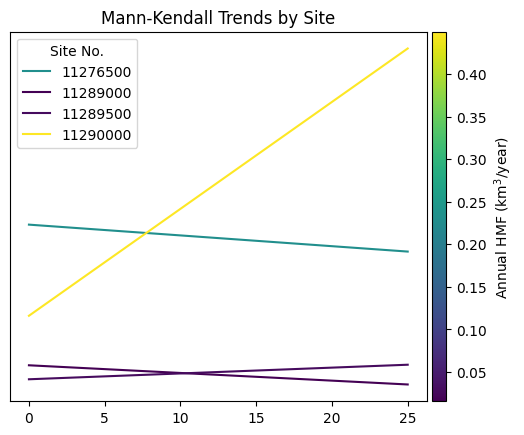

In [76]:
# REQUIRES: 'df_multi_site' from 'Gages-II Filter' OR a spreadsheet for testing
path = 'spreadsheets/ca_huc4_results.csv'
df = pd.read_csv(path)

def create_mk_plot(df: pd.DataFrame):
    """Create a plot showing Mann-Kendall trends by site"""
    # Filter only sites that show a trend
    df.reset_index(drop=True, inplace=True)
    df = df[df['mk_h'] == True]

    fig, ax = plt.subplots()

    vmin = df['hmf_per_year'].min()
    vmax = df['hmf_per_year'].max()
    norm = mcolors.Normalize(vmin, vmax)
    cmap = 'viridis'
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array(df['hmf_per_year'])

    for _, row in df.iterrows():
        slope = row['mk_slope']
        intercept = row['mk_int']
        val = row['hmf_per_year']
        
        x = np.linspace(0, 25)
        y = slope * x + intercept
        ax.plot(x, y, label=row['site_no'], color=mappable.to_rgba(val))
        
    ax.set_title('Mann-Kendall Trends by Site')
    ax.legend(title='Site No.')
    ax.axes.get_yaxis().set_ticks([])
    plt.colorbar(mappable, label='Annual HMF ($\mathregular{km^3}$/year)', ax=ax, pad=0.01, aspect=25, orientation='vertical', alpha=1.0)
    #ax.axhline(0, color='black', linewidth=1)
    #ax.axvline(0, color='black', linewidth=1)
    plt.show()

create_mk_plot(df)


## Single Region Mapping<br>

EPSG:4269


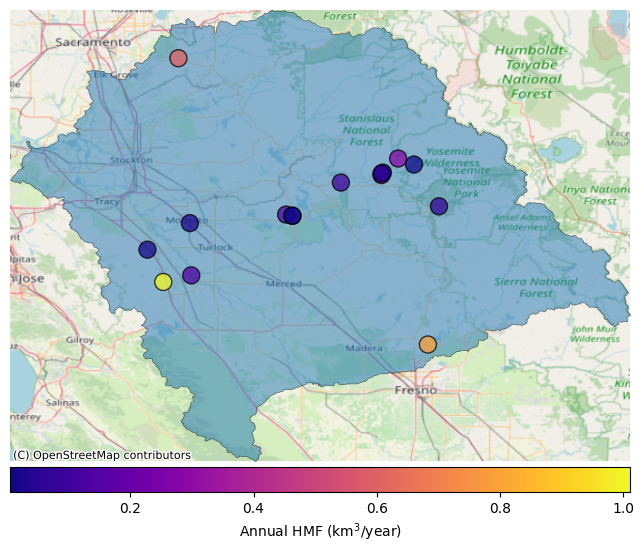

In [61]:
# REQUIRES: 'df_multi_site' from 'Gages-II Filter'

shape = gpd.read_file(shapefile_path)
print(shape.crs)

def multi_site_map(df_multi_site: pd.DataFrame, shape):
    #df = nwis.get_record(sites=SITE_NO, service='site')
    #df2 = nwis.get_record(sites='11303500', service='site')
    lat = df_multi_site['dec_lat_va'].tolist()
    long = df_multi_site['dec_long_va'].tolist()

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.margins(0)

    # This plots the WB shapefile region
    shape.plot(ax=ax, alpha=0.50, edgecolor='black', linewidth=0.5)

    geometry = [Point(xy) for xy in zip(long, lat)]
    geo_df = gpd.GeoDataFrame(geometry=geometry)

    # Set colorbar limits and theme
    vmin = df_multi_site['hmf_per_year'].min()
    vmax = df_multi_site['hmf_per_year'].max()
    norm = mcolors.Normalize(vmin, vmax)
    cmap = 'plasma'
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array(df_multi_site['hmf_per_year'])

    # This plots the datapoints
    bx = geo_df.plot(ax=ax, column=df_multi_site['hmf_per_year'], markersize=600, marker='.', cmap=cmap, edgecolor='black', linewidth=1, alpha=0.75)
    cbx = plt.colorbar(mappable, ax=bx, pad=0.01, aspect=25, orientation='horizontal', alpha=1.0)
    cbx.set_label('Annual HMF ($\mathregular{km^3}$/year)')

    #bx.set_title("WBDHU8")
    bx.margins(0, tight=True)
    bx.set_axis_off()

    # This plots the context backmap
    cx.add_basemap(bx, crs=shape.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=8)
    
multi_site_map(df_multi_site, shape)

## Statewide Mapping

In [ ]:
shapefile_path = f'ShapeFiles/OR/Whole_State/Shape/WBDHU4.shp'
shape = gpd.read_file(shapefile_path)
size_limit = 999

df_state_sites = filter_multi_site(shapefile_path)
df_multi_site = create_multi_site_data(df_state_sites, 999)
print(f'Max HMF for this region: {df_multi_site["hmf_per_year"].max():.1f}')
multi_site_map(df_multi_site, shape)

## Aquifer Mapping<br>

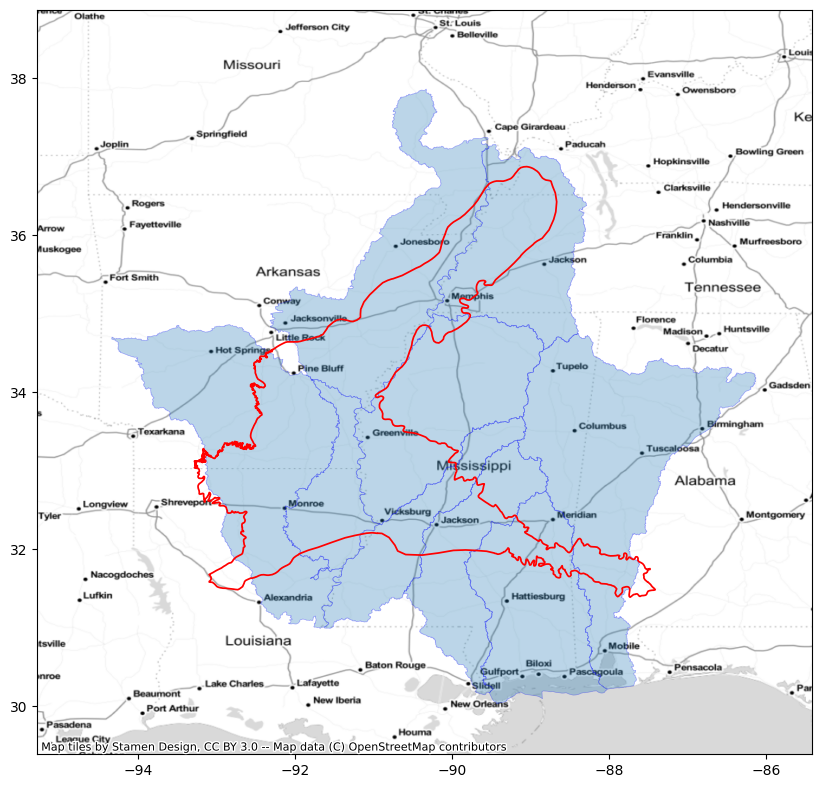

In [92]:
fig, ax = plt.subplots(figsize=(10, 10))

# HUC4 Watershed plots
directory = 'ShapeFiles/Aquifers/Upper_Clairborne_MS/HUC4'
shapefile = 'WBDHU4.shp'
state_list = ['AR', 'LA', 'MS', 'TN', 'KY', 'MO', 'AL']

for root, dirs, files in os.walk(directory):
    #print(root, dirs, files)
    if os.path.basename(root).startswith('NHD_H_'):
        if shapefile in files:
            ws_gdf = gpd.read_file(os.path.join(root, shapefile))
            ws_gdf = ws_gdf.to_crs(4269)
            ws_gdf.plot(ax=ax, edgecolor='blue', alpha=0.30, linewidth=0.5)


# Aquifer boundary plot
aq_shapefile = 'ShapeFiles/Aquifers/Upper_Clairborne_MS/sir2008-5098_UCAQ_extent.shp'
aq_gdf = gpd.read_file(aq_shapefile)
aq_gdf = aq_gdf.to_crs(4269)

xmin, ymin, xmax, ymax = aq_gdf.total_bounds
padding = 2
xmin -= padding
ymin -= padding
xmax += padding
ymax += padding

aq_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1.25)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.margins(0)
cx.add_basemap(ax, crs=shape.crs, source=cx.providers.Stamen.TonerLite, zoom=7)




## Data Visualization<br>

Rows: 47
Correlation: 0.6181660900296607


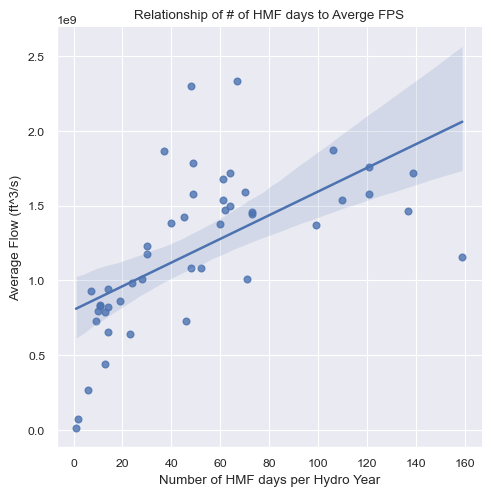

Rows: 39
Correlation w/No Outliers: 0.7340109778858692


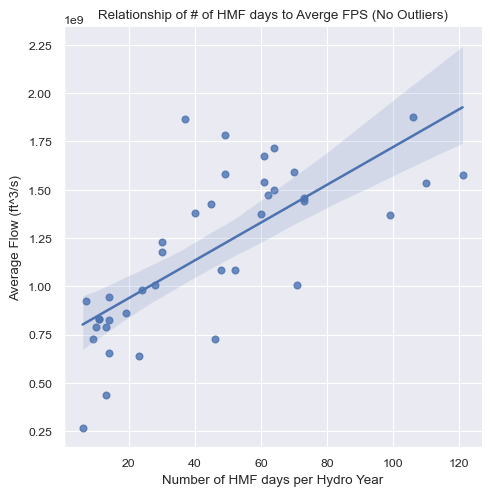

In [7]:
# Scatter plot looking at correlation between # of HMF days per hydrologic year, and average daily flow 
df = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.mean_start_date, end=curr_guage.mean_end_date)
threshold = calc_threshold(df, QUANTILE)
hmf_series = filter_hmf(df, threshold)
hmf_series = convert_hmf(hmf_series, threshold)
#hmf_series.to_csv('hmf_series.csv')
hmf_series = pd.DataFrame(hmf_series)
#hmf_series.set_index('datetime', inplace=True)

# Aggregate dataframe by total flow per day per hydro year, and # of HMF days per hydro year
df_results = hmf_series.resample(HYDRO_YEAR).agg({'00060_Mean': ['sum', 'count']})
df_results.columns = ['Sum', 'Count']
#print(df_results)

# Remove all hydrologic years with no HMF and calculate average FPS/per day
df_results = df_results[df_results['Count'] != 0]
df_results['Average FPS'] = df_results['Sum'] / df_results['Count']
print(f'Rows: {len(df_results)}')

# Correlation
corr = df_results['Count'].corr(df_results['Average FPS'])
print(f'Correlation: {corr}')

# Data Plotting

#plt.figure(figsize=(6, 6))
sns.set(color_codes=True)
sns.set_context('paper')

sns.lmplot(data=df_results, x='Count', y='Average FPS')
plt.xlabel('Number of HMF days per Hydro Year')
plt.ylabel('Average Flow (ft^3/s)')
plt.title('Relationship of # of HMF days to Averge FPS')
plt.show()

# Remove outliers w/Z-score
z_scores = np.abs((df_results - df_results.mean()) / df_results.std())
#print(z_scores)

# Somewhat arbitrary threshold that removes just the most egregious outliers
threshold = 2
df_results_no = df_results[(z_scores <= threshold).all(axis=1)]

print(f'Rows: {len(df_results_no)}')
# Correlation no outliers
corr_no = df_results_no['Count'].corr(df_results_no['Average FPS'])
print(f'Correlation w/No Outliers: {corr_no}')

#plt.figure(figsize=(6, 6))
sns.lmplot(data=df_results_no, x='Count', y='Average FPS')
plt.xlabel('Number of HMF days per Hydro Year')
plt.ylabel('Average Flow (ft^3/s)')
plt.title('Relationship of # of HMF days to Averge FPS (No Outliers)')
plt.show()